### Importing Libraries

In [16]:
#data stuff
import pandas as pd

#Modelling
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction import text
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

#NLP
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import gensim

#other
from tqdm import tqdm_notebook
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

### Cleaning Data for Modeling
- Specifying date range and road for model 
    - `start_day` and `end_day` and should be set here. 
- Formatting X to Input in Vectorizer
    - model is built on one day of data 
    - data is broken down by hour
    - all tweets from that hour are concatenated together
    
#### Data Dictionary
|Feature|Type|Dataset|Description|
|---|---|---|---|
|time|Object (datetime)|data2|Time of tweet (EDT), formatted yyyy-mm-dd hh:00:00+00:00; covers time span of hh:00 to hh:59|
|tweets|Object (string)|data2|Concatenated tweets pulled from traffic sites during that hour|  

- Formatting Y to Train X data
    - Y is built off of manually input values from reliable traffic twitter sites
    - Data is entered by hour 
    - 6 Major roadways represented in both directions

#### Data Dictionary
|Feature|Type|Dataset|Description|
|---|---|---|---|
|date|Object (datetime)|closed|Time of tweet (EDT), formatted yyyy-mm-dd hh:00:00+00:00; covers time span of hh:00 to hh:59|
|1-95 North|int|closed|Staus of major roadway in direction indicated (0 = no lane closures or incidents for duration of hour, 1 = any type of lane closure or incident during hour duration)|  
|1-95 South|int|closed|Staus of major roadway in direction indicated (0 = no lane closures or incidents for duration of hour, 1 = any type of lane closure or incident during hour duration)|  
|95 Express North|int|closed|Staus of major roadway in direction indicated (0 = no lane closures or incidents for duration of hour, 1 = any type of lane closure or incident during hour duration)|  
|95 Express South|int|closed|Staus of major roadway in direction indicated (0 = no lane closures or incidents for duration of hour, 1 = any type of lane closure or incident during hour duration)| 
|I-195 East|int|closed|Staus of major roadway in direction indicated (0 = no lane closures or incidents for duration of hour, 1 = any type of lane closure or incident during hour duration)|  
|I-195 West|int|closed|Staus of major roadway in direction indicated (0 = no lane closures or incidents for duration of hour, 1 = any type of lane closure or incident during hour duration)| 
|SR 826 North|int|closed|Staus of major roadway in direction indicated (0 = no lane closures or incidents for duration of hour, 1 = any type of lane closure or incident during hour duration)|  
|SR 826 South|int|closed|Staus of major roadway in direction indicated (0 = no lane closures or incidents for duration of hour, 1 = any type of lane closure or incident during hour duration)| 
|US-1 North|int|closed|Staus of major roadway in direction indicated (0 = no lane closures or incidents for duration of hour, 1 = any type of lane closure or incident during hour duration)|  
|US-1 South|int|closed|Staus of major roadway in direction indicated (0 = no lane closures or incidents for duration of hour, 1 = any type of lane closure or incident during hour duration)| 

- Merging data2 and closed2 such that only hours with data remain

In [17]:
start_day = 23 #  Day refers to a day in July 2019
end_day = 30 # Range is inclusive (end day is included in data)

In [18]:
def clean_X(day_read):
    data = pd.read_csv('Datasets/timeloop_'+day_read+'.csv')
    data.drop(columns=['User','User_ID','Geo'], inplace = True)
    data['Date'] = pd.to_datetime(data['Date'])
    data['Date'] = data.assign(Date=data['Date'].dt.round('H'))['Date']
    times = []
    times.append(data['Date'][0])

    for i in tqdm_notebook(data.index):
        time = data['Date'][i]
        if time != times[len(times)-1]:
            times.append(time)
        
    dic = {'time': [], 'tweets': []}

    for hour in tqdm_notebook(times):
        total = ''
        tweets = list(data[data['Date'] == hour]['Tweet'])
        for twit in tweets:
            total += str(twit)
        dic['time'].append(hour)
        dic['tweets'].append(total)
    data2 = pd.DataFrame.from_dict(dic)

    data2.set_index('time', inplace=True)
    data2.sort_index(inplace=True)
    return data2

In [19]:
data_X = pd.DataFrame()

for day in range(start_day, end_day+1):
    cleaned_X = clean_X('2019-07-' + str(day))
    data_X = pd.concat([cleaned_X, data_X])

In [20]:
data_X.to_csv('./Datasets/data_X_all_tweets')

In [21]:
closed = pd.read_csv('Datasets/manual_y - PDT.csv')
closed.rename({'Unnamed: 0': 'Date'}, axis=1, inplace=True)
closed['Date'] = pd.to_datetime(closed['Date'], utc=True) + timedelta(hours=7)
# added UTC=True to make formatting match X table
closed.set_index('Date', inplace=True)
closed.sort_index(inplace=True)

In [22]:
model_data = pd.concat([data_X, closed], axis=1, join='outer').dropna()

### Creating Model
- Train/Test Split (skipped for small initial dataset)
- Create Pipeline
- Gridsearch Parameters

In [ ]:
model_data['95 Express North'].value_counts()

In [ ]:
X = model_data['tweets']
y = model_data['95 Express North']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [ ]:
model_data.columns

#### Multinomial Naive Bayes

Best Model Performance: 
- Train score = 0.87
- Test score = 0.83

In [ ]:
pipe = Pipeline([
    ('vec', TfidfVectorizer(token_pattern='[a-zA-z]+ | [A-Za-z]+\-*\d+\W(?:[sS]outh|[Nn]orth|East|West|[NSEW]{1,2}|[nswe]{1,2})*')),
    ('nb', MultinomialNB())
])
pipe_params = {
    'vec__stop_words': ['english'],
    'vec__max_features': [2000],
    'vec__min_df': [1],
    'vec__max_df': [.6],
    'vec__ngram_range': [(2,5)],
    'nb__alpha': [.6]
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train)
print('cvs:', gs.best_score_)
print('train score:', gs.score(X_train, y_train))
print('test score:', gs.score(X_test, y_test))
gs.best_params_

#### Random Forest

Best Model Performance: 
- Train score = 0.93
- Test score = 0.8

In [ ]:
pipe = Pipeline([
    ('vec', TfidfVectorizer(token_pattern='[a-zA-z]+ | [A-Za-z]+\-*\d+\W(?:[sS]outh|[Nn]orth|East|West|[NSEW]{1,2}|[nswe]{1,2})*')),
    ('rf', RandomForestClassifier())
])

pipe_params = {
    'vec__stop_words': ['english'],
    'vec__max_features': [800, 1000, 1200],
    'vec__min_df': [2],
    'vec__max_df': [.4, .5],
    'vec__ngram_range': [(2,5)],
    'rf__n_estimators': [3],
    'rf__max_depth' : [6],
    'rf__min_samples_split' : [.17],
    'rf__criterion' : ['gini'],
    'rf__min_samples_leaf' : [1],
    'rf__max_features' : [.88]
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, n_jobs=2, verbose=10)
gs.fit(X_train, y_train)
print('cvs:', gs.best_score_)
print('train score:', gs.score(X_train, y_train))
print('test score:', gs.score(X_test, y_test))
gs.best_params_

#### Breaking out TFIDF 
- Vectorizing tweets is time consuming
- Tuning models to high performing TFIDF parameters first
- Run pipe param with vectorizer after other model parameters are tuned

In [ ]:
tfidf = TfidfVectorizer(
    token_pattern='[a-zA-z]+ | [A-Za-z]+\-*\d+\W(?:[sS]outh|[Nn]orth|East|West|[NSEW]{1,2}|[nswe]{1,2})*',
    stop_words='english',
    max_features=1000,
    min_df=2,
    max_df=.5,
    ngram_range=(2,5)
)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

#### SVC

Best Model Performance: 
- Train score = 1.0, .99
- Test score = 0.9, .87

In [ ]:
grid_params = {
    'criterion': ['gini'],
    'max_depth': [5, 6, 7],
    'max_features': [.87, 0.88, 0.88],
    'min_samples_leaf': [1],
    'min_samples_split': [0.17, 0.18, 0.19],
    'n_estimators': [3],
}

gs = GridSearchCV(RandomForestClassifier(), param_grid=grid_params, cv=3, n_jobs=2, verbose=10)
gs.fit(X_train_vec, y_train)
print('cvs:', gs.best_score_)
print('train score:', gs.score(X_train_vec, y_train))
print('test score:', gs.score(X_test_vec, y_test))
gs.best_params_

In [ ]:
pipe = Pipeline([
    ('vec', TfidfVectorizer(token_pattern='[a-zA-z]+ | [A-Za-z]+\-*\d+\W(?:[sS]outh|[Nn]orth|East|West|[NSEW]{1,2}|[nswe]{1,2})*')),
    ('svc', SVC())
])

pipe_params = {
    'vec__stop_words': ['english'],
    'vec__max_features': [1000, 2000],
    'vec__min_df': [1, 2],
    'vec__max_df': [.5, .6],
    'vec__ngram_range': [(2,5), (3,5)],
    'svc__kernel' : ['poly'],
    'svc__gamma' : [800],
    'svc__C' : [0.009],
    'svc__degree' : [1]
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, n_jobs=2, verbose=10)
gs.fit(X_train, y_train)
print('cvs:', gs.best_score_)
print('train score:', gs.score(X_train, y_train))
print('test score:', gs.score(X_test, y_test))
gs.best_params_

### Running SVC on all major roads, both directions
- Using parameters that performed best for I-95 North
- `predictions_df` is a matrix which outputs the status of each road for hours that data exists
- `performances_df` records the baseline accuracy and the train accuracy and the test accuracy

In [ ]:
roads = ['I-95 North', 'I-95 South', '95 Express North',
       '95 Express South', 'I-195 East', 'SR 826 North',
       'SR 826 South', 'SR 836 East', 'SR 836 West', 'US-1 North',
       'US-1 South']

In [28]:
X = model_data['tweets']
# vectorizing 
tfidf = TfidfVectorizer(
        token_pattern='[a-zA-z]+ | [A-Za-z]+\-*\d+\W(?:[sS]outh|[Nn]orth|East|West|[NSEW]{1,2}|[nswe]{1,2})*',
        stop_words='english',
        max_features=2000,
        min_df=1,
        max_df=.6,
        ngram_range=(2,5)
)
X_vec = tfidf.fit_transform(X)
    
    
predictions_df = pd.DataFrame()
performances_df = pd.DataFrame(
    index=['baseline acc', 'train_acc', 'test_acc'])
probs_df = pd.DataFrame()

for road in roads: 
    print(road)
    performance = []
    
    # adding baseline to performance
    values = model_data[road].value_counts()
    baseline = values[0]/values.sum()
    if baseline<0.5:
        baseline = values[1]/values.sum()
    performance.append(baseline)
    print(baseline) 
    
    # train, test, split
    y = model_data[road]
    X_train, X_test, y_train, y_test = train_test_split(X_vec, y, 
                                                        stratify=y, 
                                                        random_state=42)
    
    # modeling
    svc = SVC(kernel='poly', gamma=550, C=0.004, degree=1, probability=True)
    svc.fit(X_train, y_train)
    
    train = svc.score(X_train, y_train)
    performance.append(train)
    test = svc.score(X_test, y_test)
    performance.append(test)
    print('train score:', train)
    print('test score:', test)
    
    performances_df[road] = performance
    
    preds = svc.predict(X_vec)
    preds_df = pd.DataFrame(preds, index=X.index)
    predictions_df = pd.concat([predictions_df,preds_df], axis=1)
    
    y_probs = svc.predict_proba(X_vec)
    y_preds = y_probs[:,1]
    y_preds = pd.DataFrame(y_preds, index=X.index)
    probs_df = pd.concat([probs_df,y_preds], axis=1)

I-95 North
0.6923076923076923
train score: 1.0
test score: 0.9
US-1 South
0.7350427350427351
train score: 0.9310344827586207
test score: 0.7


In [ ]:
predictions_df.columns = ['I-95 North', 'I-95 South', '95 Express North',
       '95 Express South', 'I-195 East', 'SR 826 North',
       'SR 826 South', 'SR 836 East', 'SR 836 West', 'US-1 North',
       'US-1 South']
probs_df.columns = ['I-95 North', 'I-95 South', '95 Express North',
       '95 Express South', 'I-195 East', 'SR 826 North',
       'SR 826 South', 'SR 836 East', 'SR 836 West', 'US-1 North',
       'US-1 South']

In [ ]:
performances_df.to_csv('./Datasets/performance_svc.csv')
predictions_df.to_csv('./Datasets/predictions_svc.csv')

In [30]:
# News tweets - best and worst improvement over baseline

y_true_95N = model_data['I-95 North']
y_preds_95N = probs_df['I-95 North']

fpr_95N, tpr_95N, threshold = roc_curve(y_true_95N, y_preds_95N)

roc_auc_95N = auc(fpr_95N, tpr_95N)

y_true_1S = model_data['US-1 South']
y_preds_1S = probs_df['US-1 South']

fpr_1S, tpr_1S, threshold = roc_curve(y_true_1S, y_preds_1S)

roc_auc_1S = auc(fpr_1S, tpr_1S)

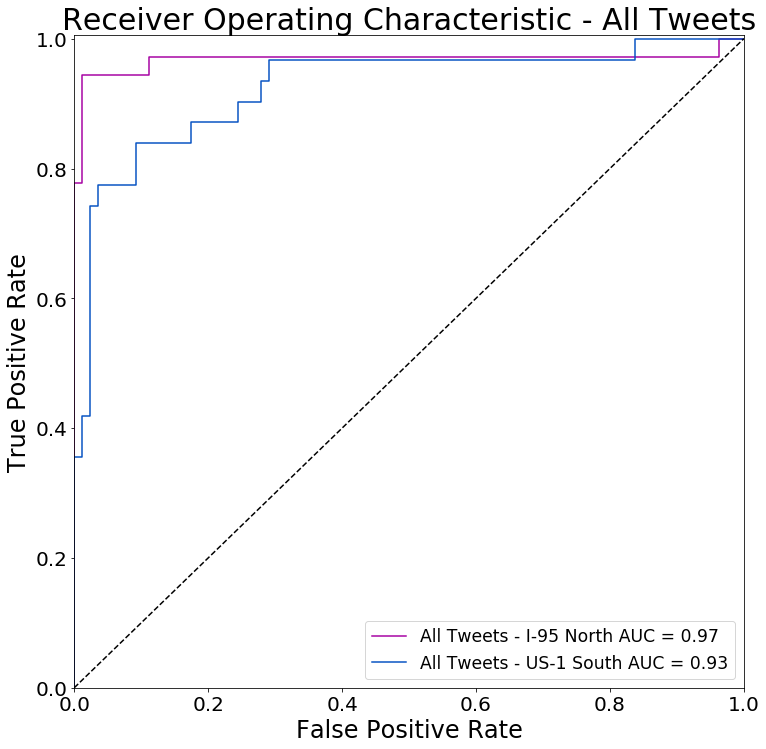

In [229]:
plt.figure(figsize=(12,12), edgecolor='#BDFFFF')
plt.title('Receiver Operating Characteristic - All Tweets', fontsize=30)
plt.plot(fpr_95N, tpr_95N, '#A601A3', label = 'All Tweets - I-95 North AUC = %0.2f' % roc_auc_95N)
plt.plot(1-fpr_1S, 1-tpr_1S, '#0652C3', label = 'All Tweets - US-1 South AUC = %0.2f' % (1-roc_auc_1S))
plt.legend(loc = 'lower right', fontsize='xx-large')
plt.legend(loc = 'lower right', fontsize='xx-large')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0, 1.005])
plt.ylabel('True Positive Rate', fontsize=24)
plt.xlabel('False Positive Rate', fontsize=24)
plt.show()

### Importing Tweets from traffic sources only

In [38]:
files = ['@TotalTrafficMIA',
         '@TrafficAlertSFL', '@nbc6', '@CBSMiami', '@wsvn', '@MiamiHerald', '@SunSentinel', '@miaminewsnow',
         '@BeachNewsAlerts', '@WPLGLocal10', 
       '@MiamiBeachPD', '@miamibeachnews', '@FLTurnpikeSFL']

In [39]:
datum = []

for filename in tqdm_notebook(files):
    data = pd.read_csv(f'Datasets/siteloop_{filename}.csv')
    data.drop(columns=['User','User_ID','Geo'], inplace = True)
    data['Date'] = pd.to_datetime(data['Date'])
    data['Date'] = data.assign(Date=data['Date'].dt.floor('H'))['Date']
    times = []
    times.append(data['Date'][0])

    for i in data.index:
        time = data['Date'][i]
        if time != times[len(times)-1]:
            times.append(time)

    dic = {'time': [], f'{filename}': []}

    for hour in times:
        total = ''
        tweets = list(data[data['Date'] == hour]['Tweet'])
        for twit in tweets:
            total += str(twit)
        dic['time'].append(hour)
        dic[f'{filename}'].append(total)
    exec(f'data_{filename[1:]} = pd.DataFrame.from_dict(dic)')
    
    exec(f'data_{filename[1:]}.set_index("time", inplace=True)')
    exec(f'data_{filename[1:]}.sort_index(inplace=True)')
    
    exec(f'datum.append(data_{filename[1:]})')
df = pd.concat(datum, axis=1)
df.fillna('', inplace=True)

In [ ]:
df.columns

In [40]:
df['tweets'] = df['@TotalTrafficMIA'] + df['@TrafficAlertSFL'] + df['@nbc6'] + \
df['@CBSMiami'] + df['@wsvn'] + df['@MiamiHerald'] + df['@SunSentinel'] + \
df['@miaminewsnow'] + df['@BeachNewsAlerts'] + df['@WPLGLocal10'] + df['@MiamiBeachPD'] + \
df['@miamibeachnews'] + df['@FLTurnpikeSFL']

In [41]:
model_data_news = pd.concat([df['tweets'], closed], axis=1, join='outer').dropna()

In [64]:
X = model_data_news['tweets']
y = model_data_news['I-95 North']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [65]:
tfidf = TfidfVectorizer(
    token_pattern='[a-zA-z]+ | [A-Za-z]+\-*\d+\W(?:[sS]outh|[Nn]orth|East|West|[NSEW]{1,2}|[nswe]{1,2})*',
    stop_words='english',
    max_features=1000,
    min_df=1,
    max_df=.6,
    ngram_range=(2,5)
)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

In [66]:
grid_params = {
    'criterion': ['gini'],
    'max_depth': [3, 4, 5],
    'max_features': [.3, .31, .32],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [.18, .19, .2],
    'n_estimators': [4, 5, 6, 7],
}

gs = GridSearchCV(RandomForestClassifier(), param_grid=grid_params, cv=3, n_jobs=2, verbose=10)
gs.fit(X_train_vec, y_train)
print('cvs:', gs.best_score_)
print('train score:', gs.score(X_train_vec, y_train))
print('test score:', gs.score(X_test_vec, y_test))
gs.best_params_

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1791s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done  22 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Batch computation too fast (0.0384s.) Setting batch_size=20.
[Parallel(n_jobs=2)]: Done 108 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done 288 tasks      | elapsed:    5.2s
[Parallel(n_jobs=2)]: Done 468 tasks      | elapsed:    6.3s
[Parallel(n_jobs=2)]: Done 688 tasks      | elapsed:    7.8s
[Parallel(n_jobs=2)]: Done 908 tasks      | elapsed:    9.1s


cvs: 0.6771300448430493
train score: 0.8251121076233184
test score: 0.56


[Parallel(n_jobs=2)]: Done 972 out of 972 | elapsed:    9.5s finished
/Users/mags/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 0.32,
 'min_samples_leaf': 4,
 'min_samples_split': 0.2,
 'n_estimators': 7}

In [ ]:
y.value_counts()[0]/y.value_counts().sum()

In [78]:
pipe = Pipeline([
    ('vec', TfidfVectorizer(token_pattern='[a-zA-z]+ | [A-Za-z]+\-*\d+\W(?:[sS]outh|[Nn]orth|East|West|[NSEW]{1,2}|[nswe]{1,2})*')),
    ('rf', RandomForestClassifier())
])

pipe_params = {
    'vec__stop_words': ['english'],
    'vec__max_features': [500, 1000, 2000],
    'vec__min_df': [1, 2],
    'vec__max_df': [.5, .8],
    'vec__ngram_range': [(2,5), (3,5), (4,5), (3,6)],
    'rf__criterion' : ['gini'],
    'rf__max_depth' : [2, 3, 4],
    'rf__max_features' : [0.3, 0.6, 0.9],
    'rf__min_samples_leaf' : [1, 2],
    'rf__min_samples_split': [0.2, 0.4, 0.6],
    'rf__n_estimators': [3, 5, 7]
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, n_jobs=2, verbose=10)
gs.fit(X_train, y_train)
print('cvs:', gs.best_score_)
print('train score:', gs.score(X_train, y_train))
print('test score:', gs.score(X_test, y_test))
gs.best_params_

In [79]:
pipe = Pipeline([
    ('vec', CountVectorizer(token_pattern='[a-zA-z]+ | [A-Za-z]+\-*\d+\W(?:[sS]outh|[Nn]orth|East|West|[NSEW]{1,2}|[nswe]{1,2})*')),
    ('rf', RandomForestClassifier())
])

pipe_params = {
    'vec__stop_words': ['english'],
    'vec__max_features': [400, 500, 600],
    'vec__min_df': [1, 2],
    'vec__max_df': [.4, .5, .6],
    'vec__ngram_range': [(3,5), (3,6)],
    'rf__criterion' : ['gini'],
    'rf__max_depth' : [3, 4],
    'rf__max_features' : [.2, 0.4, .6],
    'rf__min_samples_leaf' : [1],
    'rf__min_samples_split': [0.5],
    'rf__n_estimators': [2, 3]
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, n_jobs=2, verbose=10)
gs.fit(X_train, y_train)
print('cvs:', gs.best_score_)
print('train score:', gs.score(X_train, y_train))
print('test score:', gs.score(X_test, y_test))
gs.best_params_

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    7.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   12.1s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   16.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   19.4s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   23.5s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   27.8s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   31.5s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   35.9s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   40.8s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   46.4s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   52.6s
[Parallel(

cvs: 0.6681614349775785
train score: 0.7130044843049327
test score: 0.68


{'rf__criterion': 'gini',
 'rf__max_depth': 3,
 'rf__max_features': 0.4,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 0.5,
 'rf__n_estimators': 3,
 'vec__max_df': 0.4,
 'vec__max_features': 500,
 'vec__min_df': 2,
 'vec__ngram_range': (3, 6),
 'vec__stop_words': 'english'}

In [85]:
pipe = Pipeline([
    ('vec', CountVectorizer(token_pattern='[a-zA-z]+ | [A-Za-z]+\-*\d+\W(?:[sS]outh|[Nn]orth|East|West|[NSEW]{1,2}|[nswe]{1,2})*')),
    ('nb', MultinomialNB())
])
pipe_params = {
    'vec__stop_words': ['english'],
    'vec__max_features': [500],
    'vec__min_df': [3],
    'vec__max_df': [.18],
    'vec__ngram_range': [(5, 7)],
    'nb__alpha': [.5, .55]
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train)
print('cvs:', gs.best_score_)
print('train score:', gs.score(X_train, y_train))
print('test score:', gs.score(X_test, y_test))
gs.best_params_

cvs: 0.6457399103139013
train score: 0.726457399103139
test score: 0.64


{'nb__alpha': 0.55,
 'vec__max_df': 0.18,
 'vec__max_features': 500,
 'vec__min_df': 3,
 'vec__ngram_range': (5, 7),
 'vec__stop_words': 'english'}

In [212]:
y.value_counts(normalize=True)

0.0    0.865772
1.0    0.134228
Name: US-1 North, dtype: float64

In [210]:
X = model_data_news['tweets']
y = model_data_news['US-1 North']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [213]:
pipe = Pipeline([
    ('vec', CountVectorizer(token_pattern='[a-zA-z]+ | [A-Za-z]+\-*\d+\W(?:[sS]outh|[Nn]orth|East|West|[NSEW]{1,2}|[nswe]{1,2})*')),
    ('svc', SVC())
])

pipe_params = {
    'vec__stop_words': ['english'],
    'vec__max_features': [1500, 1600, 1700],
    'vec__min_df': [1, 2],
    'vec__max_df': [.2, .25],
    'vec__ngram_range': [(4,7)],
    'svc__kernel' : ['poly'],
    'svc__gamma' : [0, 1, 2],
    'svc__C' : [.0001, .001],
    'svc__degree' : [0, 1]
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, n_jobs=3, verbose=10)
gs.fit(X_train, y_train)
print('cvs:', gs.best_score_)
print('train score:', gs.score(X_train, y_train))
print('test score:', gs.score(X_test, y_test))
gs.best_params_

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:    3.1s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    4.1s
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:    6.7s
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    8.4s
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   11.1s
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   13.7s
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed:   17.1s
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:   19.8s
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed:   24.1s
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed:   27.7s
[Parallel(n_jobs=3)]: Done 107 tasks      | elapsed:   32.2s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:   36.7s
[Parallel(n_jobs=3)]: Done 139 tasks      | elapsed:   42.0s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   46.7s
[Parallel(

cvs: 0.8654708520179372
train score: 0.8654708520179372
test score: 0.8666666666666667


{'svc__C': 0.0001,
 'svc__degree': 0,
 'svc__gamma': 0,
 'svc__kernel': 'poly',
 'vec__max_df': 0.2,
 'vec__max_features': 1500,
 'vec__min_df': 1,
 'vec__ngram_range': (4, 7),
 'vec__stop_words': 'english'}

### Running Random Forest Classifier on all major roads, both directions
- Using parameters that performed best for I-95 North
- `predictions_df` is a matrix which outputs the status of each road for hours that data exists
- `performances_df` records the baseline accuracy and the train accuracy and the test accuracy

In [93]:
roads = ['I-95 North', 'I-95 South', '95 Express North',
       '95 Express South', 'I-195 East', 'SR 826 North',
       'SR 826 South', 'SR 836 East', 'SR 836 West', 'US-1 North',
       'US-1 South']

In [219]:
X = model_data_news['tweets']
# vectorizing 
cvec = CountVectorizer(
        token_pattern='[a-zA-z]+ | [A-Za-z]+\-*\d+\W(?:[sS]outh|[Nn]orth|East|West|[NSEW]{1,2}|[nswe]{1,2})*',
        stop_words='english',
        max_features=1700,
        min_df=1,
        max_df=.3,
        ngram_range=(4, 8)
)
X_vec = cvec.fit_transform(X)

predictions_df = pd.DataFrame()
performances_df = pd.DataFrame(
    index=['baseline acc', 'train_acc', 'test_acc'])
probs_df = pd.DataFrame()

for road in roads: 
    print(road)
    performance = []
    
    # adding baseline to performance
    values = model_data_news[road].value_counts()
    baseline = values[0]/values.sum()
    if baseline<0.5:
        baseline = values[1]/values.sum()
    performance.append(baseline)
    print(baseline)
    
    # train, test, split
    y = model_data_news[road]
    X_train, X_test, y_train, y_test = train_test_split(X_vec, y, 
                                                        stratify=y, 
                                                        random_state=42)
    
    # modeling
    svc = SVC(kernel='poly', gamma=10, C=.001, degree=0, probability=True)
    svc.fit(X_train, y_train)
    
    train = svc.score(X_train, y_train)
    performance.append(train)
    test = svc.score(X_test, y_test)
    performance.append(test)
    print('train score:', train)
    print('test score:', test)
    
    performances_df[road] = performance
    
    preds = svc.predict(X_vec)
    preds_df = pd.DataFrame(preds, index=X.index)
    predictions_df = pd.concat([predictions_df,preds_df], axis=1)
    
    y_probs = svc.predict_proba(X_vec)
    y_preds = y_probs[:,1]
    y_preds = pd.DataFrame(y_preds, index=X.index)
    probs_df = pd.concat([probs_df,y_preds], axis=1)

I-95 North
0.5234899328859061
train score: 0.5246636771300448
test score: 0.52
I-95 South
0.6140939597315436
train score: 0.6143497757847534
test score: 0.6133333333333333
95 Express North
0.5738255033557047
train score: 0.5739910313901345
test score: 0.5733333333333334
95 Express South
0.8154362416107382
train score: 0.8161434977578476
test score: 0.8133333333333334
I-195 East
0.7986577181208053
train score: 0.7982062780269058
test score: 0.8
SR 826 North
0.7785234899328859
train score: 0.7802690582959642
test score: 0.7733333333333333
SR 826 South
0.7953020134228188
train score: 0.7937219730941704
test score: 0.8
SR 836 East
0.7181208053691275
train score: 0.7174887892376681
test score: 0.72
SR 836 West
0.7248322147651006
train score: 0.726457399103139
test score: 0.72
US-1 North
0.8657718120805369
train score: 0.8654708520179372
test score: 0.8666666666666667
US-1 South
0.7986577181208053
train score: 0.7982062780269058
test score: 0.8


In [184]:
predictions_df.columns = ['I-95 North', 'I-95 South', '95 Express North',
       '95 Express South', 'I-195 East', 'SR 826 North',
       'SR 826 South', 'SR 836 East', 'SR 836 West', 'US-1 North',
       'US-1 South']
probs_df.columns = ['I-95 North', 'I-95 South', '95 Express North',
       '95 Express South', 'I-195 East', 'SR 826 North',
       'SR 826 South', 'SR 836 East', 'SR 836 West', 'US-1 North',
       'US-1 South']

In [61]:
performances_df.to_csv('./Datasets/performance_rf.csv')
predictions_df.to_csv('./Datasets/predictions_rf.csv')

In [221]:
performances_df.T['baseline acc'].mean()

0.727882855399634

In [222]:
performances_df.T['train_acc'].mean()

0.7280880554423156

In [220]:
performances_df.T['test_acc'].mean()
# change n-gram from (2,5) to (4,7)
# .64 -> 0.72

0.7272727272727272

In [185]:
# News tweets - best and worst improvement over baseline

y_true_95E = model_data_news['I-95 North']
y_preds_95E = probs_df['I-95 North']

fpr_95E, tpr_95E, threshold = roc_curve(y_true_95E, y_preds_95E)

roc_auc_95E = auc(fpr_95E, tpr_95E)

y_true_836 = model_data_news['SR 836 East']
y_preds_836 = probs_df['SR 836 East']

fpr_836, tpr_836, threshold = roc_curve(y_true_836, y_preds_836)

roc_auc_836 = auc(fpr_836, tpr_836)

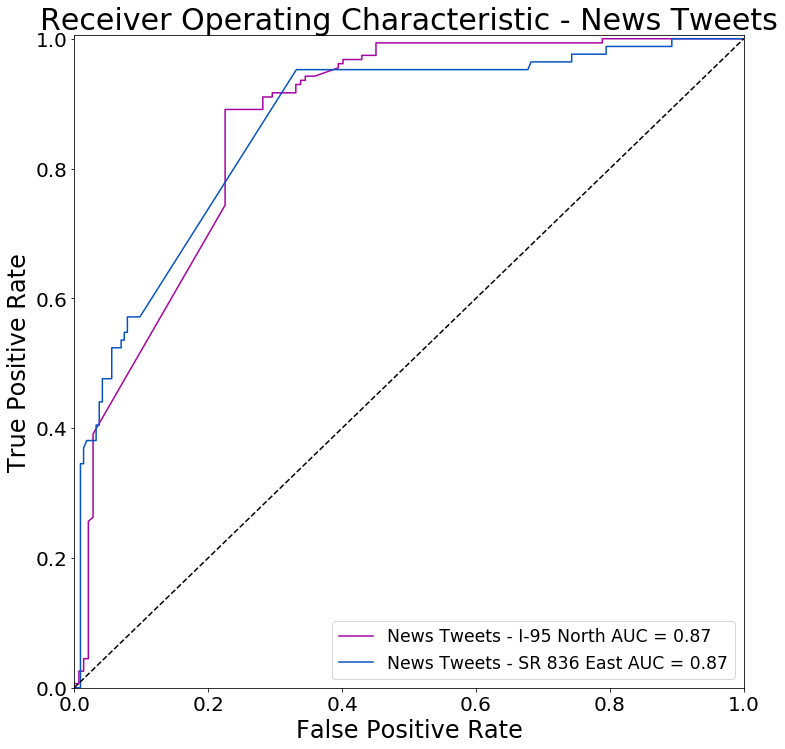

In [228]:
plt.figure(figsize=(12,12), edgecolor='#BDFFFF')
plt.title('Receiver Operating Characteristic - News Tweets', fontsize=30)
plt.plot(fpr_95E, tpr_95E, '#A601A3', label = 'News Tweets - I-95 North AUC = %0.2f' % roc_auc_95E)
plt.plot(fpr_836, tpr_836, '#0652C3', label = 'News Tweets - SR 836 East AUC = %0.2f' % roc_auc_836)
plt.legend(loc = 'lower right', fontsize='xx-large')
plt.legend(loc = 'lower right', fontsize='xx-large')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0, 1.005])
plt.ylabel('True Positive Rate', fontsize=24)
plt.xlabel('False Positive Rate', fontsize=24)
plt.show()

In [189]:
word_importance = pd.DataFrame(rf.feature_importances_, index=tfidf.get_feature_names())

ValueError: Shape of passed values is (298, 1), indices imply (1800, 1)

<1x127 sparse matrix of type '<class 'numpy.float64'>'
	with 127 stored elements in Compressed Sparse Row format>

In [56]:
word_importance.sort_values(0, ascending=False)

,0
when communication if you,0.129208
are unable more,0.125142
to appreciate,0.124459
falters when,0.123368
and beyond,0.087721
become the,0.081682
the time to,0.075194
your inner,0.074954
ketogenic ketolifestyle fittoservegroup,0.050347
jul th pm tonight,0.045838
